# Assignment

In [1]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     - S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     - X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     - allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     - R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     - Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

I added a function below to print the chess board more nicely with the enemy king being red.

In [3]:
def print_board(board):
    # for each 0 print an empty space
    # for a 1 print a K
    # for a 2 print a Q
    # for a 3 print a k
    dim1, dim2 = board.shape

    for i in range(size_board):
        # print(17*"-")
        for j in range(size_board):
            print(" | ", end="")
            if   board[i,j] == 0: print(" . ", end="")  # empty square
            elif board[i,j] == 1: print(" K ", end="")  # agent king
            elif board[i,j] == 2: print(" Q ", end="")  # agent queen
            elif board[i,j] == 3: print(" \033[91mk\033[0m ", end="")  # enemy king in red

        print(" |\n")
    # print(17*"-")
    
S = np.array([[0, 0, 0, 0],
 [3, 0, 0, 0],
 [0, 0, 1, 0],
 [0, 2, 0, 0]])

print_board(S)

 |  .  |  .  |  .  |  .  |

 |  k  |  .  |  .  |  .  |

 |  .  |  .  |  K  |  .  |

 |  .  |  Q  |  .  |  .  |



In [4]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 0 3 0]
 [0 0 0 0]
 [0 0 0 2]
 [0 1 0 0]]
check?  0
dofk2  1

[[0 0 0 0]
 [0 3 0 0]
 [0 0 0 2]
 [1 0 0 0]]
0  0
check?  0
dofk2  3

[[0 0 0 0]
 [0 0 3 0]
 [0 0 0 0]
 [1 0 0 2]]
0  0
check?  0
dofk2  2

[[0 0 3 0]
 [0 0 0 0]
 [1 0 0 0]
 [0 0 0 2]]
0  0
check?  0
dofk2  2

[[0 0 0 3]
 [0 0 0 0]
 [1 0 2 0]
 [0 0 0 0]]
0  0
check?  0
dofk2  0

[[0 0 0 3]
 [1 0 0 0]
 [0 0 2 0]
 [0 0 0 0]]
0.0  1
check?  0
dofk2  0


In [5]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=10_000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Average Number of steps: ',np.mean(N_moves_save_random))



Random_Agent, Average reward: 0.2007 Average Number of steps:  7.0098


In [6]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES



Dimensions of network:


In [8]:
def EpsilonGreedy_Policy(Qvalues, allowed_a, epsilon):
    """
    returns: tuple
        an action in form of a one-hot encoded vector with the same shapeensions as Qvalues.
        an action as decimal integer (0-based)

    Assumes only a single state, i.e. online learning and NOT (mini-)batch learning.
    """
    # get the Qvalues and the indices (relative of all Qvalues) for the allowed actions
    allowed_a_ind = np.where(allowed_a==1)[0]
    Qvalues_allowed = Qvalues[allowed_a_ind]
    

    # ------------ epsilon greedy ------------

    # draw a random number and compare it to epsilon
    rand_value = np.random.uniform(0, 1, 1)

    if rand_value < epsilon:  # if the random number is smaller than epsilon, draw a random action
        action_taken_ind_of_allwed_only = np.random.randint(0, len(allowed_a_ind))
    else:  # greedy action
        action_taken_ind_of_allwed_only = np.argmax(Qvalues_allowed)

    # get index of the action that was chosen (relative of all actions, not only allowed)
    ind_of_action_taken = allowed_a_ind[action_taken_ind_of_allwed_only]


    # ------------ create usable output ------------

    # get the shapeensions of the Qvalues
    N_a, N_samples = np.shape(Qvalues)  # N_samples must be 1

    # initialize all actions of binary mask to 0
    A_binary_mask = np.zeros((N_a,N_samples))
    # set the action that was chosen to 1
    A_binary_mask[ind_of_action_taken,:] = 1

    return A_binary_mask, ind_of_action_taken


# relu and it's derivative
def ReLU(x):
    return np.maximum(0,x)

def Heaviside(x):
    return np.heaviside(x,0)

# sigmoid and it's derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def gradient_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

# tanh and it's derivative
def tanh(x):
    return np.tanh(x)

def gradient_tanh(x):
    return 1 - np.tanh(x)**2
    




## INITALISE YOUR NEURAL NETWORK...
class NeuralNetwork(object):
    def __init__(self, N_in, N_h, N_a, activation_function="relu", method="qlearning", seed=42):
        """
        activation functions: "relu", "sigmoid", "tanh"
        methods: "qlearning", "sarsa"
        """

        # set activation function and gradient function
        if activation_function == "relu":
            self.act_f = ReLU
            self.grad = Heaviside
        elif activation_function == "sigmoid":
            self.act_f = sigmoid
            self.grad = gradient_sigmoid
        elif activation_function == "tanh":
            self.act_f = tanh
            self.grad = gradient_tanh
        else:
            raise("Invalid activation function!")

        # initialize the weights and biases
        # todo: divide by np.sqrt(N_in) and np.sqrt(N_h) respectively?
        np.random.seed(seed)
        self.W1=np.random.randn(N_h, N_in)/np.sqrt(N_in)  # standard normal distribution, shape: (N_h, N_in)
        self.b1=np.zeros((N_h, 1))
        np.random.seed(seed)
        self.W2=np.random.randn(N_a, N_h)/np.sqrt(N_h)  # standard normal distribution, shape: (N_a, N_h)
        self.b2=np.zeros((N_a, 1))

    def forward(self, x):
        """
        x has shape: (N_in, 1)
        returns:
            last logits (i.e. Qvalues) of shape (N_a, 1)
            first logits (i.e. Qvalues) of shape (N_h, 1)
        """
        # # make x a two dimensional array
        # x = np.expand_dims(x, axis=1)

        # forward pass/propagation
        z1 = self.W1@x + self.b1  # logits, i.e. pre-activation, of layer one  -> shape (N_h, 1)
        h1 = self.act_f(z1)  # relu activation of layer one  -> shape (N_h, 1)
        z2 = self.W2@h1 + self.b2  # logits, i.e. pre-activation, of layer two  -> shape (N_a, 1)
        return z2, z1

    def backward(self, R, x, z1, gamma, x_prime, future_reward, action_binary_mask):
        """
        set future_reward=True for future reward with gamma>0, False for immediate reward
        """
        # backward pass/backpropagation
        # compute the gradient of the square loss with respect to the parameters

        # make reward of shape (N_a, 1)
        R_rep = np.tile(R, (N_a, 1))
        if future_reward:  # future reward
            delta = R_rep - (self.forward(x)[0] - gamma * np.max(self.forward(x_prime)[0]))  # -> shape (N_a, 1)
        else:  # immediate reward
            delta = R_rep - self.forward(x)[0]  # -> shape (N_a, 1)
        
        # update only action that was taken
        delta = delta*action_binary_mask

        # gradient of loss wrt W2
        self.dL_dW2 = - delta @ z1.T  # -> shape (N_a, N_h)
        # gradient of loss wrt b2
        self.dL_db2 = - delta  # -> shape (N_a, 1)

        # gradient of loss wrt b1
        self.dL_db1 = - (self.W2.T @ delta) * self.grad(z1)  # -> shape (N_h, 1)
        # gradient of loss wrt W1
        self.dL_dW1 = - self.dL_db1 @ x.T  # -> shape (N_h, N_in)


    def update_parameters(self, eta):

        # update parameters on first layer
        self.W1 = self.W1 - eta * self.dL_dW1  # -> shape (N_h, N_in)
        self.b1 = self.b1 - eta * self.dL_db1  # -> shape (N_h, 1)

        # update parameters on second layer and include only the action that was taken
        self.W2 = self.W2 - eta * self.dL_dW2  # -> shape (N_a, N_h)
        self.b2 = self.b2 - eta * self.dL_db2  # -> shape (N_a, 1)



In [9]:
# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

# N_episodes = 100_000 # THE NUMBER OF GAMES TO BE PLAYED 
N_episodes = 50_000 # THE NUMBER OF GAMES TO BE PLAYED 

# chose method ("sarsa" or "qlearning")
method = "qlearning"

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


I implemented the Q learning algorithm according to the algorithm in the figure below:
I used a 2 layer neural network to learn the expected reward, i.e. Q values.

![](../figures/qlearning_algo.png)


In [10]:
# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ...


# instantiate the neural net
nn = NeuralNetwork(N_in, N_h, N_a, activation_function="relu", method=method, seed=42)



R_save_qlearning = np.zeros([N_episodes, 1])
N_moves_save_qlearning = np.zeros([N_episodes, 1])

for n in np.arange(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done = 0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S, X, allowed_a = env.Initialise_game()      ## INITIALISE GAME
    X = np.expand_dims(X, axis=1)                     ## MAKE X A TWO DIMENSIONAL ARRAY

    if method == "sarsa":
        # compute Q values for the given state
        Qvalues, z1 = nn.forward(X)  # -> shape (N_a, 1)

        # choose an action A using epsilon-greedy policy
        A_binary_mask, A_ind = EpsilonGreedy_Policy(Qvalues, allowed_a, epsilon_f)  # -> shape (N_a, 1)


    
    while Done==0:                           ## START THE EPISODE

        # compute Q values for the given state
        Qvalues, z1 = nn.forward(X)  # -> shape (N_a, 1)

        if method == "qlearning":
            # choose an action A using epsilon-greedy policy
            A_binary_mask, A_ind = EpsilonGreedy_Policy(Qvalues, allowed_a, epsilon_f)  # -> shape (N_a, 1)

        # take action and observe reward R and state S_prime
        S_next, X_next, allowed_a_next, R, Done = env.OneStep(A_ind)
        X_next = np.expand_dims(X_next, axis=1)

        
        # update Q values indirectly by updating the weights and biases directly

        if Done==1:  # THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
            nn.backward(R, X, z1, None, None, future_reward=False, action_binary_mask=A_binary_mask)
            nn.update_parameters(eta)

            # save results
            R_save_qlearning[n]=np.copy(R)  # reward per episode
            N_moves_save_qlearning[n]=np.copy(i)  # nr moves per episode

            # print results every 1000 episodes
            if n % 1000 == 0:
                print(f"episode: {n}, reward: {R:.0f}, N_moves: {i}, epsilon: {epsilon_f:.3f}")

            break

        else:  # IF THE EPISODE IS NOT OVER...

            if method == "sarsa":
                Qvalues, z1 = nn.forward(X_next)
                # chose next action and save it
                A_binary_mask_next, A_ind_next = EpsilonGreedy_Policy(Qvalues, allowed_a_next, epsilon_f)
                A_ind = np.copy(A_ind_next)

            nn.backward(R, X, z1, gamma, X_next, future_reward=True, action_binary_mask=A_binary_mask)
            nn.update_parameters(eta)
            


            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

    # todo: record max possible reward per episode

    # bug: i always get an error on line 111 of chess_env.py in the function OneStep()


episode: 0, reward: 0, N_moves: 2, epsilon: 0.200
episode: 1000, reward: 0, N_moves: 1, epsilon: 0.190
episode: 2000, reward: 1, N_moves: 3, epsilon: 0.182
episode: 3000, reward: 1, N_moves: 2, epsilon: 0.174
episode: 4000, reward: 0, N_moves: 1, epsilon: 0.167
episode: 5000, reward: 1, N_moves: 39, epsilon: 0.160
episode: 6000, reward: 0, N_moves: 16, epsilon: 0.154
episode: 7000, reward: 1, N_moves: 1, epsilon: 0.148
episode: 8000, reward: 1, N_moves: 12, epsilon: 0.143
episode: 9000, reward: 1, N_moves: 5, epsilon: 0.138
episode: 10000, reward: 1, N_moves: 2, epsilon: 0.133
episode: 11000, reward: 1, N_moves: 2, epsilon: 0.129
episode: 12000, reward: 0, N_moves: 17, epsilon: 0.125
episode: 13000, reward: 0, N_moves: 9, epsilon: 0.121
episode: 14000, reward: 1, N_moves: 3, epsilon: 0.118
episode: 15000, reward: 0, N_moves: 11, epsilon: 0.114
episode: 16000, reward: 1, N_moves: 6, epsilon: 0.111
episode: 17000, reward: 1, N_moves: 1, epsilon: 0.108
episode: 18000, reward: 1, N_moves: 

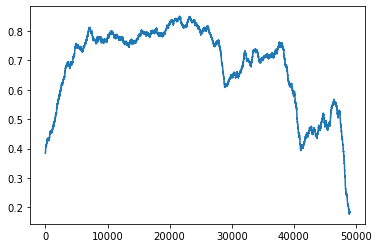

In [11]:
def moving_average(a, n=3) :
    steps = len(a)-n
    ma = np.full(steps, np.nan)
    for i in range(steps):
        ma[i] = np.mean(a[i:i+n])
    return ma, np.arange(steps)

# todo: use exponential moving average 

def exponential_moving_average(array, alpha=0.1):
    """
    Calculate exponential moving average of an array
    """
    exponential_average = np.zeros(len(array))
    exponential_average[0] = array[0]
    for i in range(1, len(array)):
        exponential_average[i] = alpha * array[i] + (1 - alpha) * exponential_average[i-1]
    return exponential_average

ma, steps = moving_average(R_save_qlearning, n=1000)
plt.plot(steps, ma)

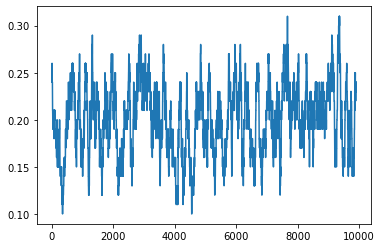

In [12]:
ma, steps = moving_average(R_save_random, n=100)
plt.plot(steps, ma)

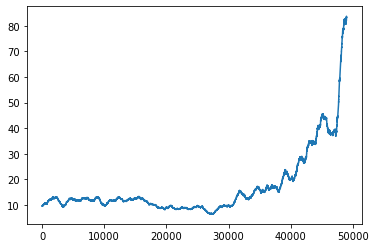

In [13]:
ma, steps = moving_average(N_moves_save_qlearning, n=1000)
plt.plot(steps, ma)